In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
import sim
import time
import math
import threading

configs = {
  "grid-size": (50, 50),
  "map-x-limits": np.array([-5, 5]),
  "map-y-limits": np.array([-5, 5]),
  "runtime-limit": 40,
  "sensor-max-dist": 5,
  "noise-std": 0,
  "num-robos": 2
}

grid = np.ones(configs["grid-size"]) / 2
subgrids = np.vsplit(grid, configs["num-robos"])

mapa = np.array([])

l_occ = np.log(0.65 / 0.35)
l_free = np.log(0.35 / 0.65)
l_0 = 0

In [2]:
class Robo:
    def __init__(self, nome):
        returnCode, handle = sim.simxGetObjectHandle(clientID, nome, sim.simx_opmode_oneshot_wait)     
        
        # Handle para as juntas das RODAS
        returnCode, l_wheel = sim.simxGetObjectHandle(clientID, nome + "_leftMotor", sim.simx_opmode_oneshot_wait)
        returnCode, r_wheel = sim.simxGetObjectHandle(clientID, nome + "_rightMotor", sim.simx_opmode_oneshot_wait)    
        
        # Cada robô lê o seu sensor.
        self.NOME_SENSOR = "hokuyo_range_data" + nome[-1]

        # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
        # Em loop até garantir que as leituras serão válidas
        returnCode = 1
        while returnCode != 0:
            returnCode, range_data = sim.simxGetStringSignal(clientID, self.NOME_SENSOR, sim.simx_opmode_streaming + 10)
            returnCode, self.floor = sim.simxGetObjectHandle(clientID, "ResizableFloor_5_25", sim.simx_opmode_oneshot_wait)

        self.scan_range = 180 * np.pi / 180
        self.step_size = 2 * np.pi / 1024
        
        # Encontra a posição do robô em relação ao mundo
        returnCode, self.pos = sim.simxGetObjectPosition(clientID, handle, -1, sim.simx_opmode_streaming)
        
        # Dados do Pioneer
        self.L = 0.381   # Metros
        self.r = 0.0975  # Metros
        self.id = handle
        self.roda_esq, self.roda_dir = l_wheel, r_wheel
        self.laser_data = []
        self.mapa, self.celulas_mapeadas = np.array([]), 0
        
        # Velocidade básica (linear, angular)
        self.v, self.w = 0, np.deg2rad(0)
    
    def ja_mapeou_regiao(self):
        return self.celulas_mapeadas == self.mapa.size
    
    def get_mapa(self):
        return self.mapa
        
    def leia_sensores(self):
        returnCode = 1
        while returnCode != 0:
          returnCode, string_range_data = sim.simxGetStringSignal(clientID, self.NOME_SENSOR, sim.simx_opmode_buffer)
          raw_range_data = sim.simxUnpackFloats(string_range_data)
          self.laser_data = format_laser_data(raw_range_data, self.scan_range, self.step_size)
        
        returnCode = 1
        while returnCode != 0:
            
          # Encontra a rotação relativa do chão em relação ao robô
          returnCode, floor_r = sim.simxGetObjectOrientation(clientID, self.floor, self.id, sim.simx_opmode_streaming)

          # Cria a matriz de transformação
          floor_m = create_matrix(self.pos, Rz(floor_r[2]))
        
        robot_grid_x, robot_grid_y = discretize_pos(self.pos[0], self.pos[1], configs)
        
        readings = []
        for (ang, dist) in self.laser_data:
          if dist < configs["sensor-max-dist"]:
            dist += np.random.normal(0, configs["noise-std"])
            ang += np.random.normal(0, configs["noise-std"])

            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            real_pos = floor_m @ np.array([x, y, 0, 1])

            grid_x, grid_y = discretize_pos(real_pos[0], real_pos[1], configs)
            rr, cc = line(robot_grid_x, robot_grid_y, grid_x, grid_y)

            line_pos = [(x, y) for x, y in zip(rr, cc)]
            readings.append((line_pos[1:], dist))
        
        return readings
    
    def move(self):
        ''' Lógica de movimentação. Caso a frente esteja vazia, ande para a frente,
        caso contrário vire para um lado vazio '''
        
        frente = int(len(self.laser_data) / 2)
        lado_direito = int(len(self.laser_data) * 1 / 4)
        lado_esquerdo = int(len(self.laser_data) * 3 / 4)

        if self.laser_data[frente, 1] > 2:
            self.v = 0.5
            self.w = 0
        elif self.laser_data[lado_direito, 1] > 2 or self.laser_data[lado_direito, 1] > self.laser_data[lado_esquerdo, 1]:
            self.v = 0
            self.w = np.deg2rad(-30)
        elif self.laser_data[lado_esquerdo, 1] > 2 or self.laser_data[lado_direito, 1] < self.laser_data[lado_esquerdo, 1]:
            self.v = 0
            self.w = np.deg2rad(30)
    
        # Isso é o modelo cinemático, estudaremos detalhadamente depois!
        wl = self.v / self.r - (self.w * self.L) / (2 * self.r)
        wr = self.v / self.r + (self.w * self.L) / (2 * self.r)
        
        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, self.roda_esq, wl, sim.simx_opmode_streaming + 5)
        sim.simxSetJointTargetVelocity(clientID, self.roda_dir, wr, sim.simx_opmode_streaming + 5)        
        
        # Encontra a posição do robô em relação ao mundo
        returnCode, self.pos = sim.simxGetObjectPosition(clientID, self.id, -1, sim.simx_opmode_streaming)
    
    def pare(self):
      sim.simxSetJointTargetVelocity(clientID, self.roda_dir, 0, sim.simx_opmode_oneshot_wait)
      sim.simxSetJointTargetVelocity(clientID, self.roda_esq, 0, sim.simx_opmode_oneshot_wait)        
    
    def escolha_regiao_para_mapear(self):
        global subgrids
        
        if len(subgrids) > 0:
            self.mapa = subgrids.pop()
            self.celulas_mapeadas = 0
        
    def atualizar_mapa(self, readings, r=0.1):
      for reading in readings:
        grid_line = reading[0]
        dist = reading[1]
        p_line = np.zeros(len(grid_line))
        for i in range(len(grid_line)):
          line_dist = (dist / len(grid_line)) * (i + 1)
          if line_dist < (dist - r / 2):
            p_line[i] = l_free
          elif line_dist >= (dist - r / 2) and line_dist <= (dist + r / 2):
            p_line[i] = l_occ
          else:
            p_line[i] = 0.5

        for pos, val in zip(grid_line, p_line):
          self.mapa[pos] = self.mapa[pos] + val - l_0
        
        self.celulas_mapeadas += len(grid_line)

In [3]:
def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta),  np.cos(theta), 0],
                   [0            ,  0            , 1]])

def create_matrix(translation, rotation, scale=1):
    return np.array([[rotation[0][0], rotation[1][0], rotation[2][0], translation[0]],
                   [rotation[0][1], rotation[1][1], rotation[2][1], translation[1]],
                   [rotation[0][2], rotation[1][2], rotation[2][2], translation[2]],
                   [0             , 0             , 0             , scale]])

def format_laser_data(range_data, scan_range, step_size, max_sensor_range=5):
    laser_data = []
    range_data = np.asarray(range_data)
    pts = math.floor(scan_range / step_size)
    angle = -scan_range * 0.5
    for i in range(pts):
        dist = range_data[i]        
        if dist <= 0:
            dist = max_sensor_range
        laser_data.append([angle, dist])
        angle = angle + step_size

    return np.array(laser_data)

def discretize_pos(x, y, config):
    min_x, max_x = config["map-x-limits"] 
    min_y, max_y = config["map-y-limits"]
    grid_size_x, grid_size_y = config["grid-size"][0] // config["num-robos"] , config["grid-size"][1] 

    clipped_x = np.clip(x, min_x, max_x)
    clipped_y = np.clip(y, min_y, max_y)
    new_x = int(np.floor((clipped_x - min_x) / (max_x - min_x) * grid_size_x))
    new_y = int(np.floor((clipped_y - min_y) / (max_y - min_y) * grid_size_y))

    return min(new_x, grid_size_x - 1), min(int(new_y), grid_size_y - 1)

def juntar_mapa(submapa):
    global mapa
    
    if mapa.size == 0:
        mapa = submapa
    else:
        np.vstack((mapa, submapa))

Program started
Connected to remote API server


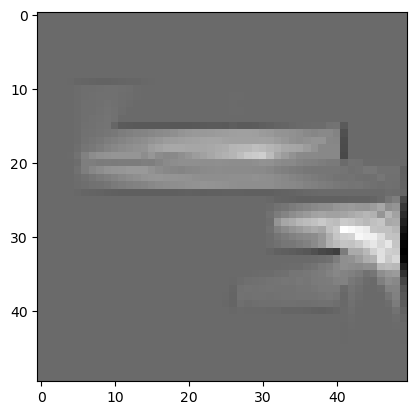

Program ended


In [4]:
print ("Program started")
sim.simxFinish(-1)
clientID = sim.simxStart("127.0.0.1", 19999, True, True, 5000, 5)

if clientID != -1:
  print ("Connected to remote API server")

  robos = [Robo("/robo" + str(i)) for i in range(configs["num-robos"])]
  
  t = 0
  startTime = time.time()
  lastTime = startTime
  iteration = -1

  while t < configs["runtime-limit"]:
    iteration += 1
    now = time.time()
    dt = now - lastTime
    
    for i in range(configs["num-robos"]):
        if robos[i].ja_mapeou_regiao() and len(subgrids) == 0:
            robos[i].pare()
            break
        elif robos[i].ja_mapeou_regiao() and len(subgrids) > 0:
            m = robos[i].get_mapa()
            juntar_mapa(m)
            robos[i].escolha_regiao_para_mapear()
        
        leituras = robos[i].leia_sensores() 
        robos[i].atualizar_mapa(leituras)
        robos[i].move()
                   
    t = t + dt  
    lastTime = now

  sim.simxStopSimulation(clientID, sim.simx_opmode_blocking)         
  sim.simxFinish(clientID)

else:
  print ("Failed connecting to remote API server")

plt.imshow(grid, cmap="Greys")
plt.show()
    
print ("Program ended")